In [1]:
import os #
import random #
import numpy as np #
import pandas as pd #
import multiprocessing as mp #
import matplotlib.pyplot as plt #

In [2]:
%load_ext rpy2.ipython

In [1]:
%%R
library(ggplot2)
library(RColorBrewer)
library(ggbeeswarm)
library(dplyr)
library(tidyverse)
library(broom)

UsageError: Cell magic `%%R` not found.


### Load pool of clonotypes and filter out non-functional and non-public clones (with a given threshold of "incidence"=20)

In [2]:
#-----import public clones-----
pool_AB_=pd.read_csv("/projects/fmba_covid/adaptive_new/pool/pool.aa.table.20+.txt", sep = '\t') 
pool_FMBA_=pd.read_csv("/projects/fmba_covid/fmba_new/pool/TRB.pool.aa.table.txt", sep = '\t') 

In [66]:
pool_AB=pool_AB_.loc[pool_AB_.incidence>20]
pool_FMBA=pool_FMBA_.loc[pool_FMBA_.incidence>20]

In [75]:
#-----filter out bed clones-----
pool_filter_AB=[x for x in list(pool_AB.cdr3aa) if ('_' or '*' or '~')  not in str(x)] 
pool_filter_AB=[x for x in  list(pool_filter_AB.cdr3aa) if  len(x)>=9 and len(x)<=17]
pool_filter_FMBA=[x for x in  list(pool_FMBA.cdr3aa) if ('_' or '*' or '~')  not in str(x)]
pool_filter_FMBA=[x for x in list(pool_filter_FMBA.cdr3aa) if  len(x)>=9 and len(x)<=17]
print('lenght_pool_AB:', len(pool_filter_AB))
print('lenght_pool_FMBA:', len(pool_filter_FMBA))

lenght_pool_AB: 19516
lenght_pool_FMBA: 8926


In [76]:
pool_filter=set(pool_filter_AB)|set(pool_filter_FMBA)
print('lenght_pool:', len(pool_filter))

lenght_pool: 19965


### Define functions to calculate the weight of a clone variant in a sample (different distance metrics between sequences are used)

In [37]:
#-----calculate the weight of the clone in the sample with the possibility of one mismatch and segment accounting-----
#-----merge groups of V segments-----
def merge_V_groups(TRBV):
    if "-" in TRBV:
        TRBV=TRBV[:TRBV.rfind('-')]
    return TRBV           

#-----pool_FMBA-----
pool_FMBA_v=list(map(merge_V_groups, list(pool_FMBA.v)))
#-----create clone and V-segment correspondence dictionaries-----
dct_pool_v=dict(zip(list(pool_FMBA.cdr3aa), list(pool_FMBA_v)))
dct_accosiated_clones_v={x:dct_pool_v[x] for x in pool_filter_FMBA}
#-----create a strings with CDR3aa and V-segments delimited by "@"-----
pool_FMBA_v=list(map(lambda x: x+f'@{dct_accosiated_clones_v[x]}', pool_filter_FMBA))

In [7]:
def hamming_distance(clone1, clone2):
    return sum(c1 != c2 for c1, c2 in zip(clone1, clone2))

In [10]:
#-----calculate the weight of the clone in the sample with the possibility of one mismatch and segment accounting-----
def get_clonotypes_frequences_hamming1_Vsegment(sample_name, path_to_folder_with_sample, clones_for_analyse):
#------make a dictionary, initialize by all zeroes-----
    local_clonesV_in_samples=dict([(xT,0) for xT in clones_for_analyse])
#------read clonotype tabel-----    
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        total_counts=0
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.strip().split("\t")
            total_counts+=1 #clone count
#------zero or one mismatch is amino acid CDR3aa sequence------
            for cloneV_of_interest in local_clonesV_in_samples:
                clone_of_interest=cloneV_of_interest[:cloneV_of_interest.rfind('@')]
                v_of_interest=cloneV_of_interest[cloneV_of_interest.rfind('@')+1:]
                if len(clone_of_interest)==len(clone[0]): 
                    if hamming_distance(clone_of_interest, clone[0])<=1 and v_of_interest==clone[4]:
                        local_clonesV_in_samples[cloneV_of_interest]+=float(clone[2])         
        return (sample_name, local_clonesV_in_samples)           

In [133]:
#-----calculate the weight of the clone in the sample with the possibility of one mismatch-----

def get_clonotypes_frequences_hamming(sample_name, path_to_folder_with_sample, clones_for_analyse):
#------initialize by all zeroes------    
    local_clones_in_samples=dict([(xT,0) for xT in clones_for_analyse]) 
#------read clonotype tabel------    
    with open(str(path_to_folder_with_sample)+"/"+str(sample_name),"r") as clonotype_file:
        for clone in clonotype_file.readlines()[1:]: #skip header
            clone=clone.split()
#------zero or one mismatch (clone[0] is amino acid CDR3 sequence)------
            for clone_of_interest in local_clones_in_samples:
                if len(clone_of_interest)==len(clone[0]): 
                    if hamming_distance(clone_of_interest, clone[0])<=1: 
#-----clone[3] is the frequency of CDR3 sequence in sample                    
                        local_clones_in_samples[clone_of_interest]+=float(clone[3])
        return (sample_name, local_clones_in_samples)

In [86]:
#-----calculate the weight of the clone in the sample-----

def get_clonotypes_frequences(sample_name, path_to_folder_with_sample, clones_for_analyse):
#------initialize by all zeroes------    
    local_clones_in_samples=dict([(xT,0) for xT in clones_for_analyse]) 
#------read clonotype tabel------    
    clonotype_file=pd.read_csv(str(path_to_folder_with_sample)+"/"+str(sample_name), sep='\t', index_col=0)
#------complete sequence match------    
    sample_clones=clonotype_file.index
    sample_public=set(clones_for_analyse)&set(sample_clones)
    sample_public_freq=clonotype_file.loc[sample_public, "freq"].to_dict() 
    local_clones_in_samples.update(sample_public_freq) 
    return (sample_name, local_clones_in_samples)

### Find fraction of clonotypes of interest (pool_filter) in samples

In [137]:
%%time
folder_with_samples="../../random_forest_v4_top/DOWNSAMPLING_TOP_5000/FMBA_top_5000AA/" 
output_folder="FREQ_TABLES/FMBA/FMBA_top_5000AA"
output_file_name=output_folder+"/"+"FMBA_pool_filter.tsv"
public_clones=pool_filter

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()- 20)) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones])) 

FREQ_TABLES/FMBA/FMBA_top_5000AA
START
DONE
CPU times: user 1.88 s, sys: 5.52 s, total: 7.39 s
Wall time: 4min 48s


In [138]:
%%time
folder_with_samples="../../random_forest_v4_top/DOWNSAMPLING_TOP_5000/HIP_top_5000AA/" 
output_folder="FREQ_TABLES/HIP/HIP_top_5000AA/"
output_file_name=output_folder+"/"+"HIP_pool_filter.tsv"
public_clones=pool_filter

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()- 20)) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones])) 

FREQ_TABLES/HIP/HIP_top_5000AA/
START
DONE
CPU times: user 1.16 s, sys: 4.76 s, total: 5.92 s
Wall time: 2min 53s


In [139]:
%%time
folder_with_samples="../../random_forest_v4_top/DOWNSAMPLING_TOP_5000/KECK_top_5000AA/" 
output_folder="FREQ_TABLES/KECK/KECK_top_5000AA/"
output_file_name=output_folder+"/"+"KECK_pool_filter.tsv"
public_clones=pool_filter

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()- 20)) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones])) 

FREQ_TABLES/KECK/KECK_top_5000AA/
START
DONE
CPU times: user 202 ms, sys: 4.2 s, total: 4.4 s
Wall time: 40.1 s


In [140]:
%%time
folder_with_samples="../../random_forest_v4_top/DOWNSAMPLING_TOP_5000/Adaptive_top_5000AA/" 
output_folder="FREQ_TABLES/Adaptive/Adaptive_top_5000AA/"
output_file_name=output_folder+"/"+"Adaptive_pool_filter.tsv"
public_clones=pool_filter

#----read sample names-----
samples=pd.read_csv(str(folder_with_samples)+"/metadata.txt",sep="\t",
                   header=None)
samples=list(samples[0])

#-----make output folder-----
print(output_folder)
try:
    os.mkdir(output_folder)
except:
    pass

#----find fraction of clonotypes of interest in samples------
def get_clonotypes_frequences_hamming_wrapper(sample_name,
                                                   path_to_folder_with_sample=folder_with_samples,
                                                   clones_for_analyse=public_clones):
    return get_clonotypes_frequences_hamming(sample_name,
                                                  path_to_folder_with_sample=path_to_folder_with_sample,
                                                  clones_for_analyse=clones_for_analyse)

#-----multiprocessing-----
print("START")    
pool = mp.Pool(processes = (mp.cpu_count()- 10)) 
results=pool.map(get_clonotypes_frequences_hamming_wrapper, samples)
pool.close()
clones_in_samples=dict(results)
print("DONE")

#-----save results-----
bad_files=0
with open(output_file_name,"w") as out_file:
    out_file.write("\t".join(public_clones))
    for sample_name in clones_in_samples:
            out_file.write("\n")
            out_file.write(str(sample_name)+"\t")
            out_file.write("\t".join([str(clones_in_samples[sample_name][clone]) for clone in public_clones]))   

FREQ_TABLES/Adaptive/Adaptive_top_5000AA/
START
DONE
CPU times: user 2.06 s, sys: 7.05 s, total: 9.11 s
Wall time: 4min 39s


### Load metadata and select cohorts of COVID+/COVID- samples in obtained datasets

In [34]:
#-----read FMBA metadata------
FMBA_metadata=pd.read_csv("../../fmba/fmba_metadata_edited.tsv",
                          sep=",",header=0, dtype = str)
print("FMBA_metadata \n", FMBA_metadata.COVID_status.value_counts())

#-----read Adaptive metadata------
AB_metadata=pd.read_csv("../../adaptive/adaptive-metadata-edited.tsv",sep="\t")
AB_metadata["sample_short_name"]=AB_metadata["sample_name"].apply(lambda x: x[:-5]) #remove _TCRB from end of names
print("\nAdaptive_metadata \n", AB_metadata["COVID-19-status"].value_counts())

gkb23_metadata=pd.read_csv("/home/daria/github/tcr-association/fmba/data_1629382412360.tsv", sep=',')
gkb23_metadata.index=list(map(lambda x: x[0 : (x.rfind("R")-1)], gkb23_metadata["R2"]))
print("\ngkb23_metadata \n" ,gkb23_metadata['SARS-CoV2_Tcell_response_level'].value_counts())

FMBA_metadata 
 COVID       1061
healthy      433
precovid     118
unknown       27
Name: COVID_status, dtype: int64

Adaptive_metadata 
 acute        1140
recovered     239
baseline       74
exposed        26
non-acute       4
Name: COVID-19-status, dtype: int64

gkb23_metadata 
 0-1 (no response)    42
>100                 40
3-6                  35
10-20                34
10-                   1
Name: SARS-CoV2_Tcell_response_level, dtype: int64


In [41]:
#----select FMBA cohorts-----
fmba_IgM_pos = set(FMBA_metadata.loc[FMBA_metadata['COVID_IgM']=='yes', "name"])
print("fmba_IgM_pos:", len(fmba_IgM_pos))
fmba_IgM_neg_IgG_pos = set(FMBA_metadata.loc[(FMBA_metadata['COVID_IgM']=='no')&((FMBA_metadata['COVID_IgG']=='yes')), "name"])
print("fmba_IgM_neg_IgG_pos:", len(fmba_IgM_neg_IgG_pos))
fmba_PCR=set(FMBA_metadata.loc[FMBA_metadata['COVID_PCR']=='positive', "name"])
print("fmba_PCR:", len(fmba_PCR))
fmba_COVID=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='COVID', "name"])
print("fmba_COVID:", len(fmba_COVID))
fmba_healthy=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='healthy', "name"])
print("fmba_healthy:", len(fmba_healthy))
fmba_precovid=set(FMBA_metadata.loc[FMBA_metadata['COVID_status']=='precovid', "name"])
print("fmba_precovid:", len(fmba_precovid))

#----select Adaptive cohorts-----
adaptive_acute=set(AB_metadata.loc[AB_metadata["COVID-19-status"]=="acute","sample_short_name"])
print("\nAdaptive_acute:",  len(adaptive_acute))

#-----select gkb23 cohorts-----
gkb23_no_response=set(gkb23_metadata.loc[gkb23_metadata['SARS-CoV2_Tcell_response_level']=='0-1 (no response)'].index)
print("\ngkb23_no_response:", len(gkb23_no_response))
gkb23_3_6=set(gkb23_metadata.loc[gkb23_metadata['SARS-CoV2_Tcell_response_level']=='3-6'].index)
print("\ngkb23_3_6:", len(gkb23_3_6))
gkb23_10_20=set(gkb23_metadata.loc[gkb23_metadata['SARS-CoV2_Tcell_response_level']=='10-20'].index)
print("\ngkb23_10_20:", len(gkb23_10_20))
gkb23_100=set(gkb23_metadata.loc[gkb23_metadata['SARS-CoV2_Tcell_response_level']=='>100'].index)
print("\ngkb23_100:", len(gkb23_100))

fmba_IgM_pos: 525
fmba_IgM_neg_IgG_pos: 432
fmba_PCR: 39
fmba_COVID: 1061
fmba_healthy: 433
fmba_precovid: 118

Adaptive_acute: 1140

gkb23_no_response: 42

gkb23_3_6: 35

gkb23_10_20: 34

gkb23_100: 40


In [97]:
%%time
#-----read Adaptive and HIP data-----
AB_data=pd.read_csv("FREQ_TABLES/Adaptive/Adaptive_top_5000AA/Adaptive_pool_filter.tsv",
                    sep="\t")
#----short sample name-----
AB_data.index=[xT.split("_")[0] for xT in AB_data.index]

HIP_data=pd.read_csv("FREQ_TABLES/HIP/HIP_top_5000AA/HIP_pool_filter.tsv",
                    sep="\t")
#----short sample name-----
HIP_data.index=[xT.split(".")[0] for xT in HIP_data.index]

KECK_data=pd.read_csv("FREQ_TABLES/KECK/KECK_top_5000AA/KECK_pool_filter.tsv",
                    sep="\t")
#----short sample name-----
KECK_data.index=[xT.split("_")[0] for xT in KECK_data.index]

#----read FMBA data------
FMBA_data=pd.read_csv("FREQ_TABLES/FMBA/FMBA_top_5000AA/FMBA_pool_filter.tsv",
                    sep="\t")
#----short sample name-----
FMBA_data.index=list(map(lambda x: x[0 : (x.rfind("S")-1)], FMBA_data.index))

CPU times: user 570 ms, sys: 80.1 ms, total: 650 ms
Wall time: 714 ms


In [98]:
FMBA_data_=FMBA_data.loc[FMBA_data.index.isin(fmba_COVID) | FMBA_data.index.isin(fmba_healthy) | FMBA_data.index.isin(fmba_precovid)]
FMBA_data_.loc[FMBA_data_.index.isin(fmba_COVID) , "status"]="COVID"
FMBA_data_.loc[FMBA_data_.index.isin(fmba_healthy) , "status"]="healthy"
FMBA_data_.loc[FMBA_data_.index.isin(fmba_precovid) , "status"]="healthy"

AB_data_=AB_data.loc[AB_data.index.isin(adaptive_acute)]
AB_data_["status"]="COVID"
HIP_data["status"]="healthy"
KECK_data["status"]="healthy"
AB_data_=pd.concat([AB_data_, HIP_data, KECK_data])

In [99]:
FMBA_AB_data=pd.concat([FMBA_data_, AB_data_])
FMBA_AB_data=FMBA_AB_data.dropna()
FMBA_AB_data.to_csv("FREQ_TABLES/RELATED_DATA/Adaptive_FMBA_top_5000AA/Adaptive_FMBA_pool_filter.tsv",
                   sep="\t")

### Apply Wilcoxon signed-rank test to data to find COVID-enriched clonotypes

In [335]:
%%R
data=read.csv('UNWEIGHT_TABLES/RELATED_DATA/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_COVID_top_20000.tsv', sep="\t", header=TRUE)
data$status <- as.factor(data$status)
n_col=dim(data)[2]

wilcox.p.value <- function(x) { wilcox.test(table(data$status, data[,x]))$p.value}
wilcox.parameter <- function(x) { wilcox.test(table(data$status, data[,x]))$parameter}
wilcox.dm <- function(x) {
  y=tapply(data[,x], data$status, mean)
  y[1]-y[2]}

dm=sapply(2:n_col, wilcox.dm)
tt <-data.frame(feature=colnames(data)[2:n_col],p.value=sapply(2:n_col,wilcox.p.value),dm=dm, stringsAsFactors = F)
sign.clones<-tt[tt[, 'p.value']<0.01 & tt[, 'dm'] > 0, ] #!dm must be > 0 (COVID+)
sign.clones <- sign.clones[order(sign.clones$p.value, decreasing = FALSE),]
write.table(sign.clones, file='WILCOX_TEST_RESULTS/UNWEIGHT/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_public_top_20000.tsv', quote=FALSE, sep='\t')

### Сalculate the cumulative frequencies of COVID-associated clonotypes in each sample 

In [142]:
COVID_associated_clones=pd.read_csv("WILCOX_TEST_RESULTS/FREQ/Adaptive_FMBA_top_public_2000AA/Adaptive_KECK_FMBA_PRECOVID_public.tsv",
                    sep="\t")
COVID_associated_clones=list(COVID_associated_clones.feature)
COVID_associated_clones=list(filter(lambda clone: len(clone)>9 and len(clone)<17, COVID_associated_clones))
print("COVID_associated_clones:", len(COVID_associated_clones))

COVID_associated_clones: 3803


In [ ]:
COVID_SUM=FMBA_AB_data.sum(axis=1).to_frame(name="WEIGHT_SUM")
COVID_SUM.loc[COVID_SUM.index.isin(Adaptive) , "COHORT"]="Adaptive"
COVID_SUM.loc[COVID_SUM.index.isin(HIP) , "COHORT"]="HIP"
COVID_SUM.loc[COVID_SUM.index.isin(KECK) , "COHORT"]="KECK"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_COVID) , "COHORT"]="COVID"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_HEALTHY) , "COHORT"]="HEALTHY"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_PRECOVID) , "COHORT"]="PRECOVID"
COVID_SUM.loc[COVID_SUM.index.isin(FMBA_PRECOVID|FMBA_COVID|FMBA_HEALTHY) , "dataset"]="FMBA"
COVID_SUM.loc[COVID_SUM.index.isin(Adaptive|HIP|KECK) , "dataset"]="Adaptive"
COVID_SUM.to_csv("BOXPLOTS/FREQ/Adaptive_FMBA_top_5000AA/Adaptive_FMBA_COVID_markers.tsv", sep="\t")

### Along the y axis shows the cumulative frequencies of COVID-associated clonotypes in each sample, along the x axis shows cohorts of dоnors 

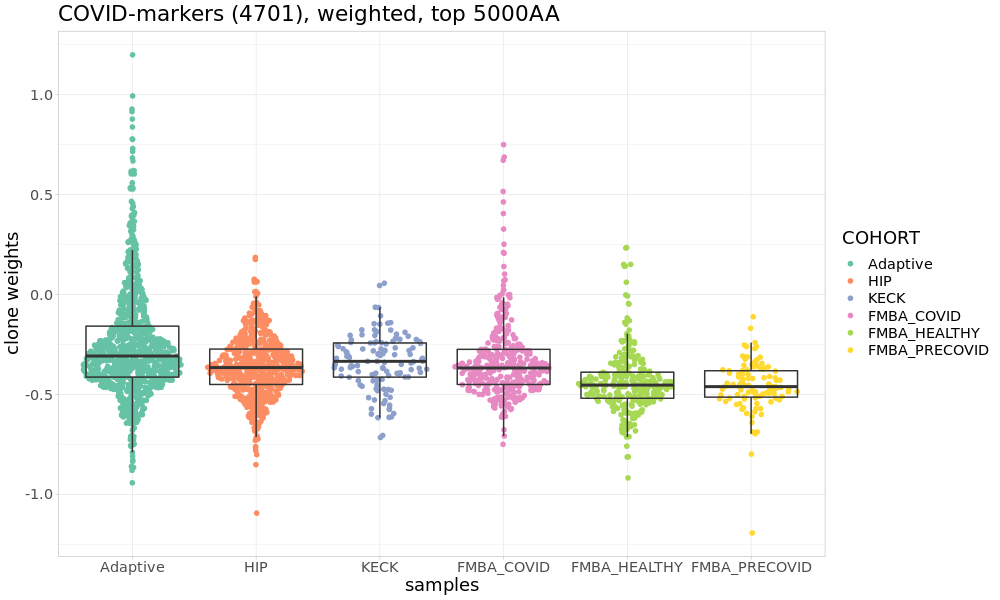

In [152]:
%%R  -w 1000 -h 600
#top 5000AA
#weighted
#-----clones found by Wilcox test (4701) from public clones FMBA and Adaptive----- 
data=read.csv('BOXPLOTS/FREQ/Adaptive_FMBA_top_5000AA/Adaptive_FMBA_COVID_markers.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("COVID-markers (4701), weighted, top 5000AA")

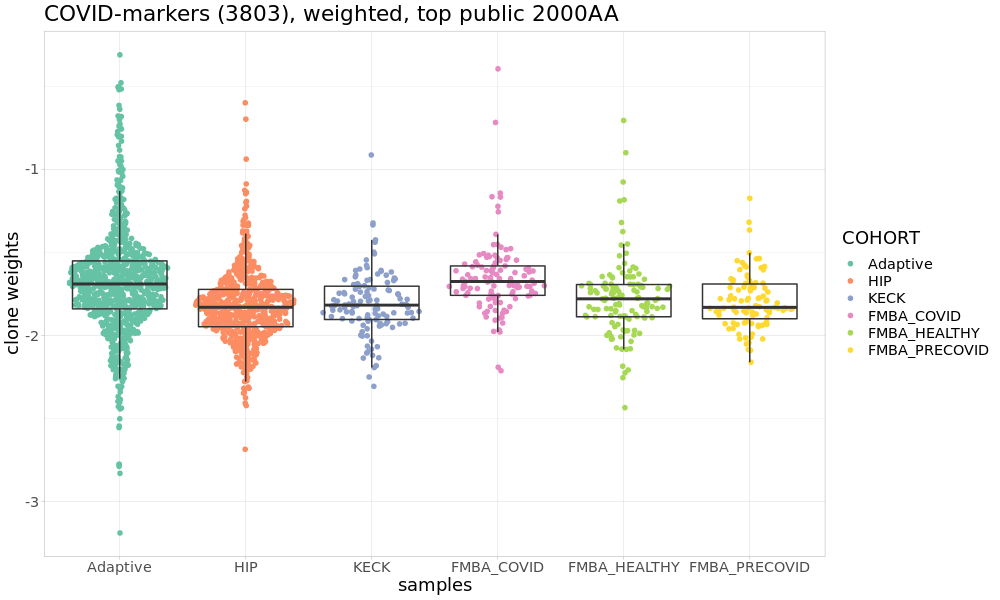

In [350]:
%%R  -w 1000 -h 600
#top public 2000AA
#weighted
#-----clones found by Wilcox test (3803) from public clones FMBA and Adaptive-----  
data=read.csv('BOXPLOTS/FREQ/Adaptive_FMBA_top_public_2000AA/Adaptive_FMBA_COVID_markers.tsv', sep="\t", header=TRUE)
data$COHORT=factor(data$COHORT,  
                   levels=c("Adaptive", "HIP", "KECK", "FMBA_COVID", "FMBA_HEALTHY", "FMBA_PRECOVID"))
ggplot(data, aes(x=COHORT, y=log10(WEIGHT_SUM))) +  
  theme(panel.background = element_rect(fill = "white", colour = "grey50")) + 
  geom_quasirandom(method = 'pseudorandom', aes(colour=COHORT), size = 2) +
  geom_boxplot(notch=FALSE, outlier.size = 0.7, lwd=0.7, alpha = 0) +
  scale_color_brewer(palette = "Set2") +
  theme_light() +              
  theme(text=element_text(size=18,  family="Comic Sans MS")) +
  labs(y= "clone weights", x = "samples") +
  ggtitle("COVID-markers (3803), weighted, top public 2000AA")